In [ ]:
# default_exp core

# shrinkwrap

Unwrapping InSAR interferograms.

> API details.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

from nbdev.showdoc import *

In [ ]:
# export
import numpy as np
from scipy import sparse as sp
from scipy.fft import dctn, idctn

In [ ]:
# export
def make_differentiation_matrices(rows, columns, boundary_conditions='neumann', dtype=np.float32):
    """Generate derivative operators as sparse matrices.
    
    Matrix-vector multiplication is the fastest way to compute derivatives
    of large arrays, particularly for images. This function generates
    the matrices for computing derivatives. If derivatives of the same
    size array will be computed more than once, then it generally is
    faster to compute these arrays once, and then reuse them.

    The three supported boundary conditions are 'neumann' (boundary
    derivative values are zero), 'periodic' (the image ends wrap around 
    to beginning), and 'dirichlet' (out-of-bounds elements are zero). 
    'neumann' seems to work best for solving the unwrapping problem.
    
    Source: 
    https://github.com/rickchartrand/regularized_differentiation/blob/master/regularized_differentiation/differentiation.py
    """
    bc_opts = ['neumann', 'periodic', 'dirichlet']
    bc = boundary_conditions.strip().lower()
    if bc not in bc_opts:
        raise ValueError(f"boundary_conditions must be in {bc_opts}")
        
    # construct derivative with respect to x (axis=1)
    D = sp.diags([-1., 1.], [0, 1], shape=(columns, columns),
                 dtype=dtype).tolil()

    if boundary_conditions.lower() == bc_opts[0]:  # neumann
        D[-1, -1] = 0.
    elif boundary_conditions.lower() == bc_opts[1]:  # periodic
        D[-1, 0] = 1.
    else:
        pass

    S = sp.eye(rows, dtype=dtype)
    Dx = sp.kron(S, D, 'csr')

    # construct derivative with respect to y (axis=0)
    D = sp.diags([-1., 1.], [0, 1], shape=(rows, rows),
                 dtype=dtype).tolil()

    if boundary_conditions.lower() == bc_opts[0]:
        D[-1, -1] = 0.
    elif boundary_conditions.lower() == bc_opts[1]:
        D[-1, 0] = 1.
    else:
        pass

    S = sp.eye(columns, dtype=dtype)
    Dy = sp.kron(D, S, 'csr')

    return Dx, Dy

In [ ]:
# export
def make_laplace_kernel(rows, columns):
    """Generate eigenvalues of diagonalized Laplacian operator
    
    Used for quickly solving the linear system ||D \Phi - phi|| = 0
    
    References:
    Numerical recipes, Section 20.4.1, Eq. 20.4.22 is the Neumann case
    or https://elonen.iki.fi/code/misc-notes/neumann-cosine/
    """
    # Note that sign is reversed from numerical recipes eq., since 
    # here since our operator discretization sign reversed
    xi_y = (2 - 2*np.cos(np.pi * np.arange(rows)/rows)).reshape((-1, 1))
    xi_x = (2 - 2*np.cos(np.pi * np.arange(columns)/columns)).reshape((1, -1))
    eigvals = xi_y + xi_x

    K = np.nan_to_num(1 / eigvals, posinf=0, neginf=0)
    return K

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Dy')

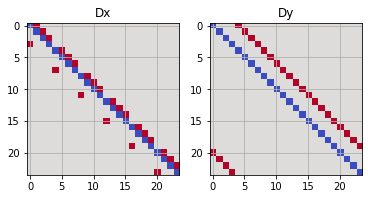

In [ ]:
rows, cols = 6, 4
dx, dy = make_differentiation_matrices(rows, cols, boundary_conditions='periodic')

fig, axes = plt.subplots(1, 2)
axr = axes.ravel()
axr[0].imshow((dx.todense()), cmap='coolwarm')
axr[0].grid(True)
axr[0].set_title("Dx")
axr[1].imshow((dy.todense()), cmap='coolwarm')
axr[1].grid(True)
axr[1].set_title("Dy")